In [1]:
import sys
import pathlib

ROOT = pathlib.Path(".").absolute().parent.parent
sys.path.append(str(ROOT))

In [2]:
from utils.metrics import (
    plot_classification_report,
    print_scores
)
import os
import pickle
from datasets.SPCUP22DataModule import SPCUP22DataModule
from features.audio import MFCC
from utils.config import load_config_file
from torchvision.transforms import Compose
from tqdm import tqdm
import numpy as np

/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_config = load_config_file(ROOT.joinpath("config", "train_params.yaml"))[
    "svm"
]

In [4]:
checkpoint_path = ROOT.joinpath(
    "checkpoints", "svm", "without_unseen", "svm-03-12-2022-20-46-01-0.05.pkl"
)
result_save_path = ROOT.joinpath("results", "svm", "without_unseen")

In [5]:
classifier = None
with open(checkpoint_path, "rb") as checkpoint_file_object:
    classifier = pickle.load(checkpoint_file_object)

In [6]:
n_mfcc = train_config["features"]["n_mfcc"]
hop_length = train_config["features"]["hop_length"]

In [7]:
batch_size = train_config["training"]["batch_size"]
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

In [8]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "spcup22").absolute()),
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()
test_dataloader = data_module.test_dataloader()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_eval_part1.zip]...


In [9]:
actual_labels = []
predicted_labels = []
predicted_probabilities = []

for batch in tqdm(test_dataloader):
    samples, current_actual_labels = batch
    samples = np.reshape(samples, newshape=(batch_size, -1))
    actual_labels.extend(current_actual_labels.tolist())
    
    current_predicted_probabilities = classifier.predict_proba(samples)
    current_predicted_labels = np.argmax(
        current_predicted_probabilities, axis=1
    )
    
    predicted_probabilities.extend(current_predicted_probabilities.tolist())
    predicted_labels.extend(current_predicted_labels.tolist())

100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


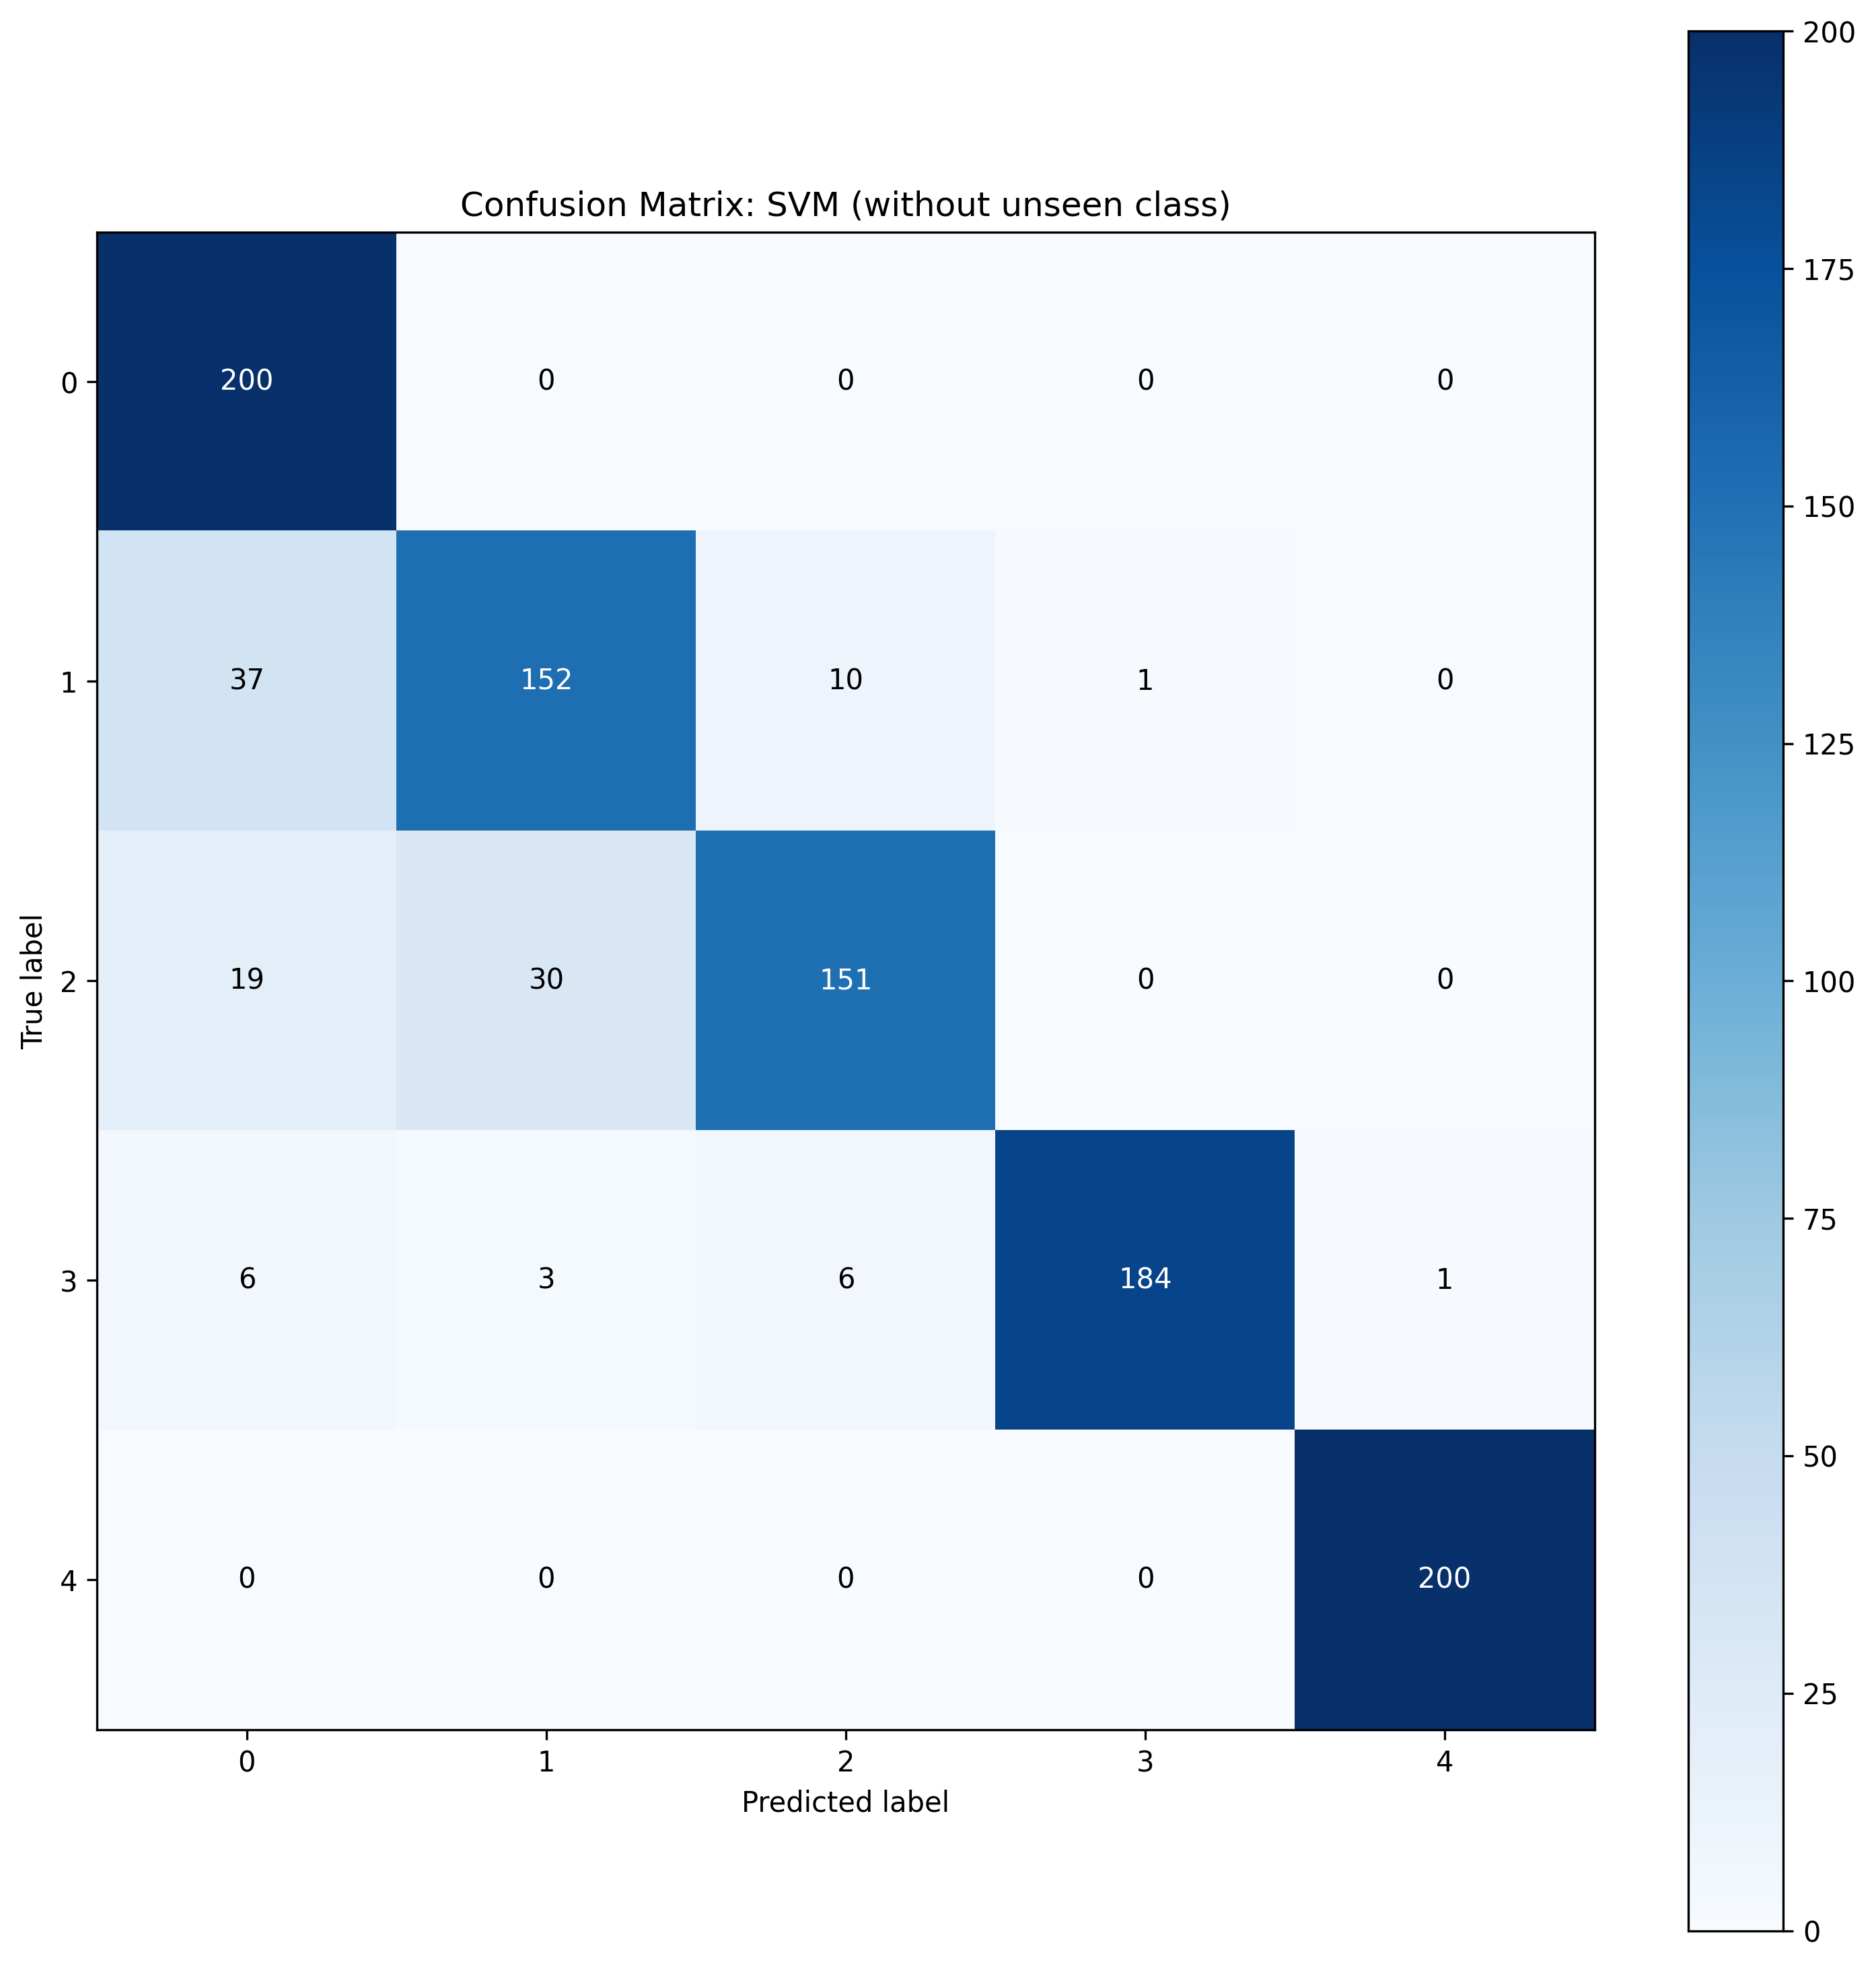

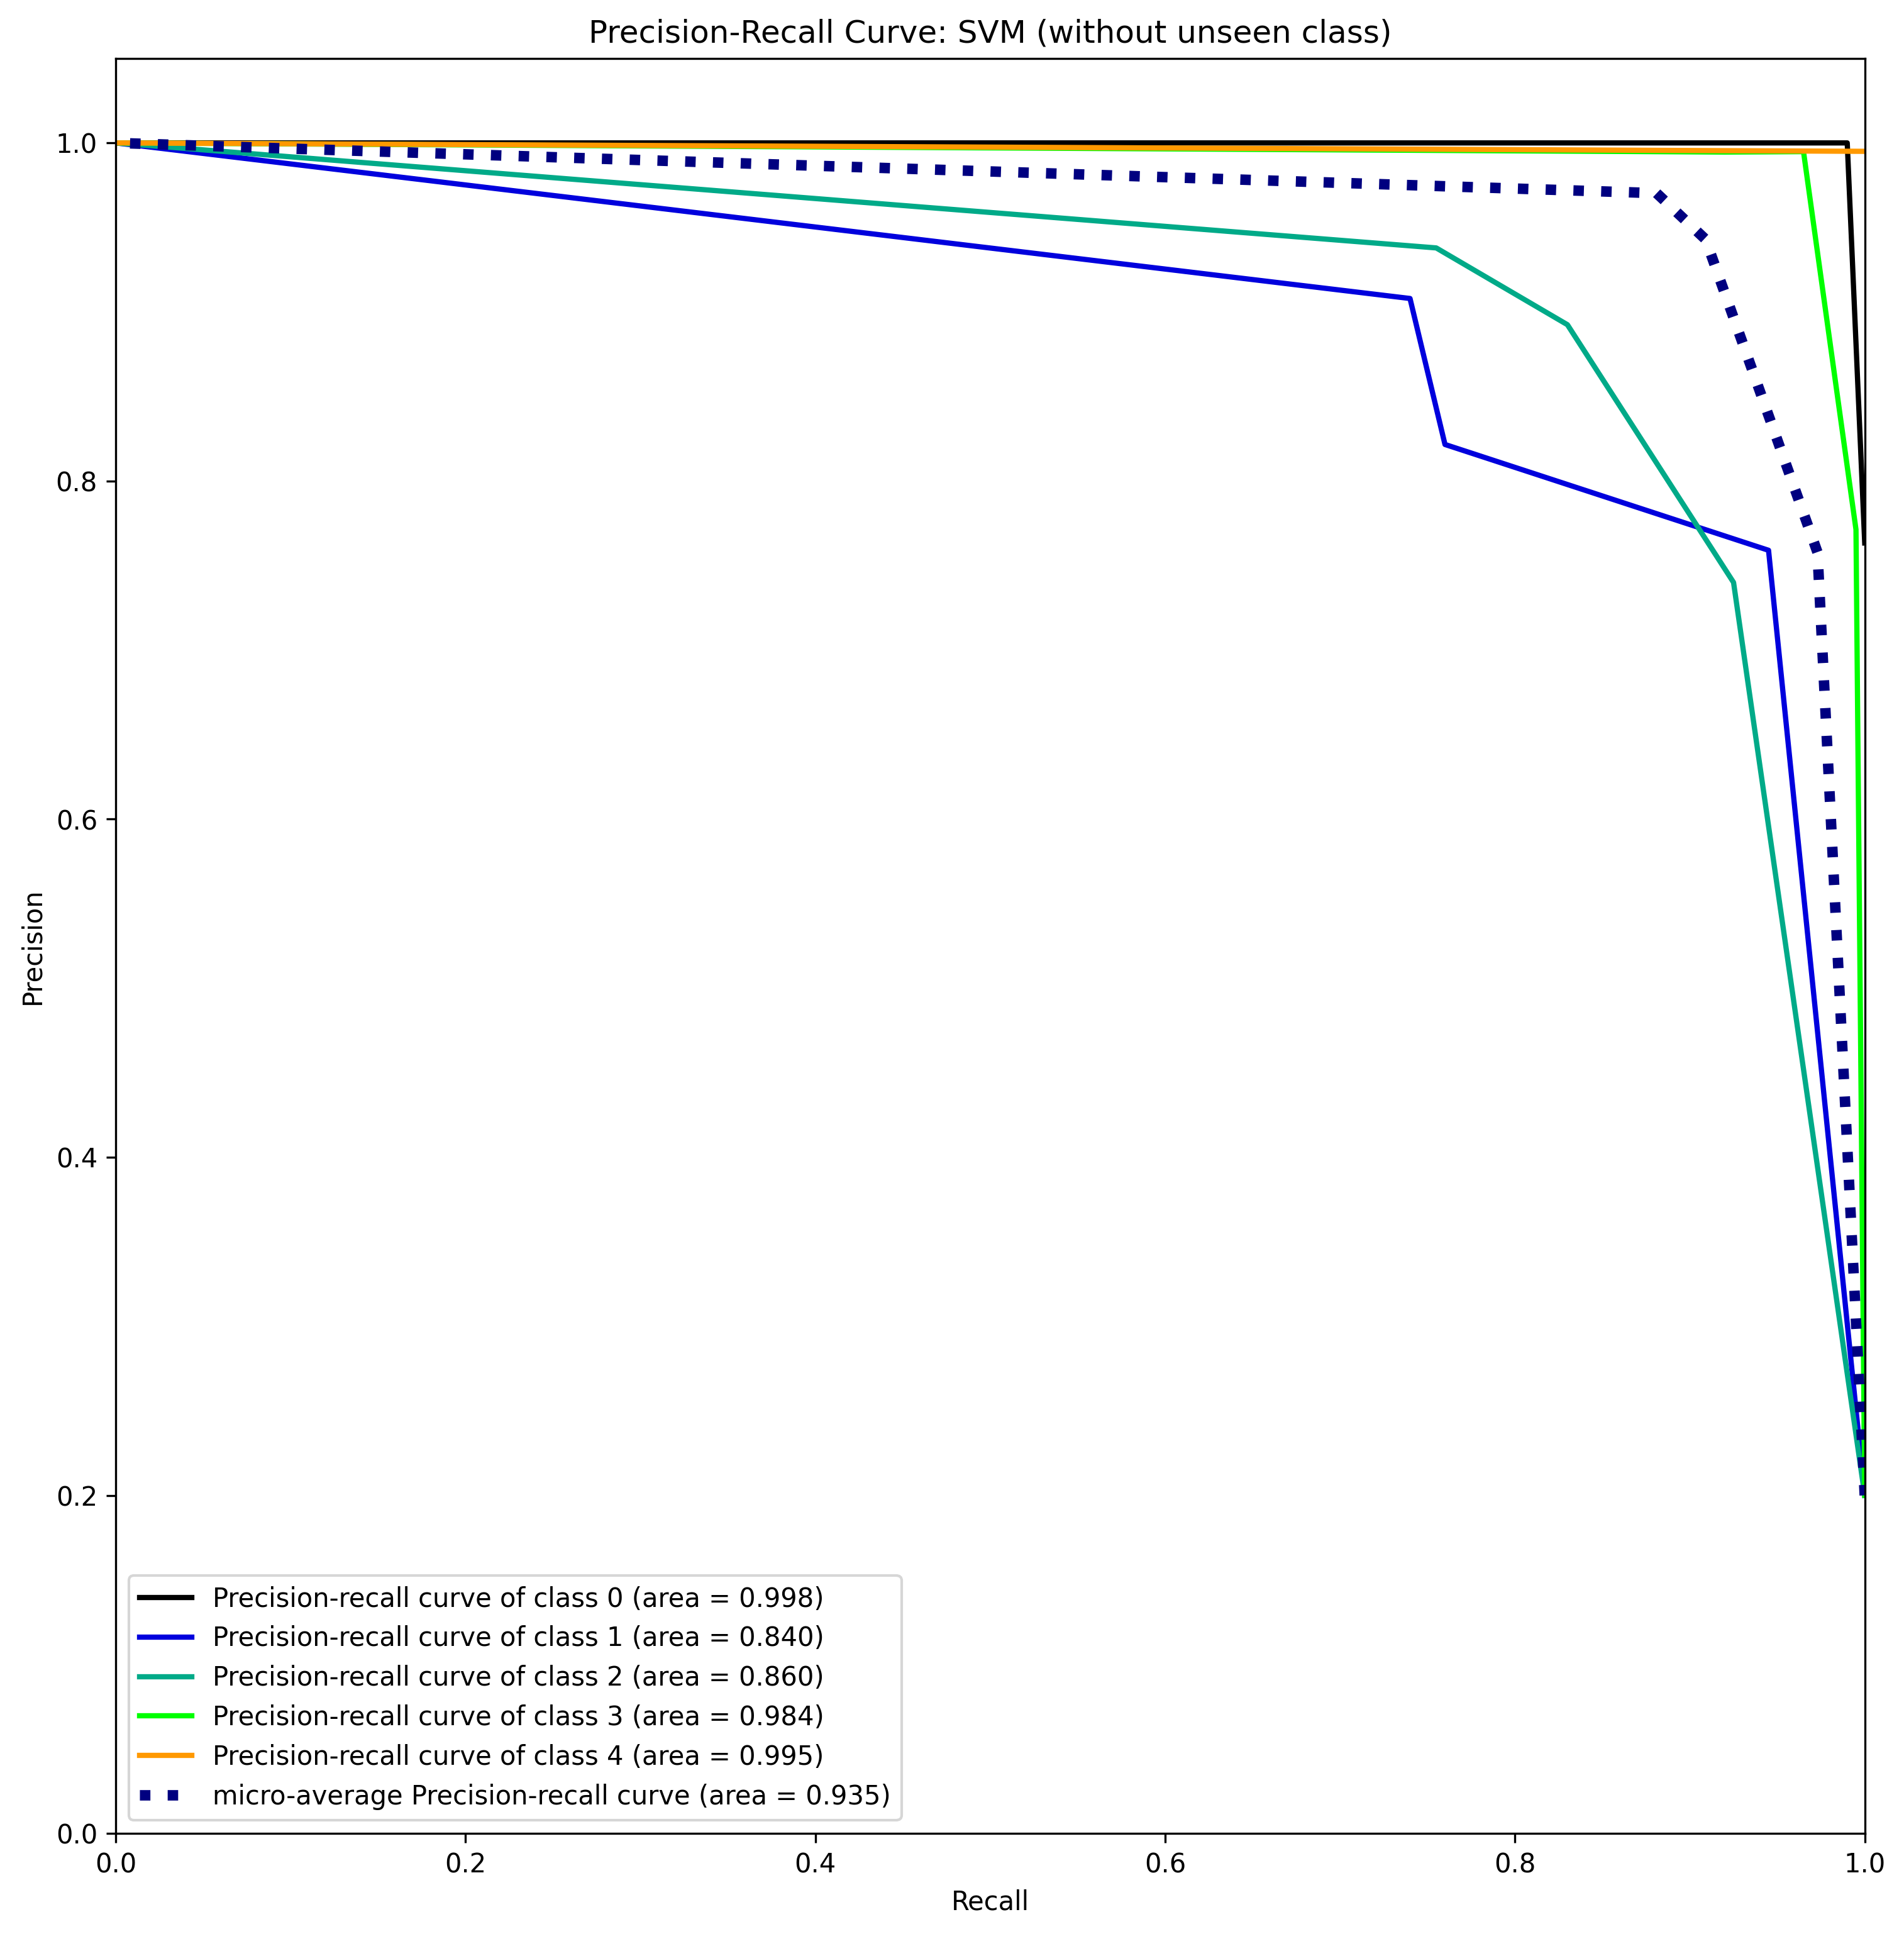

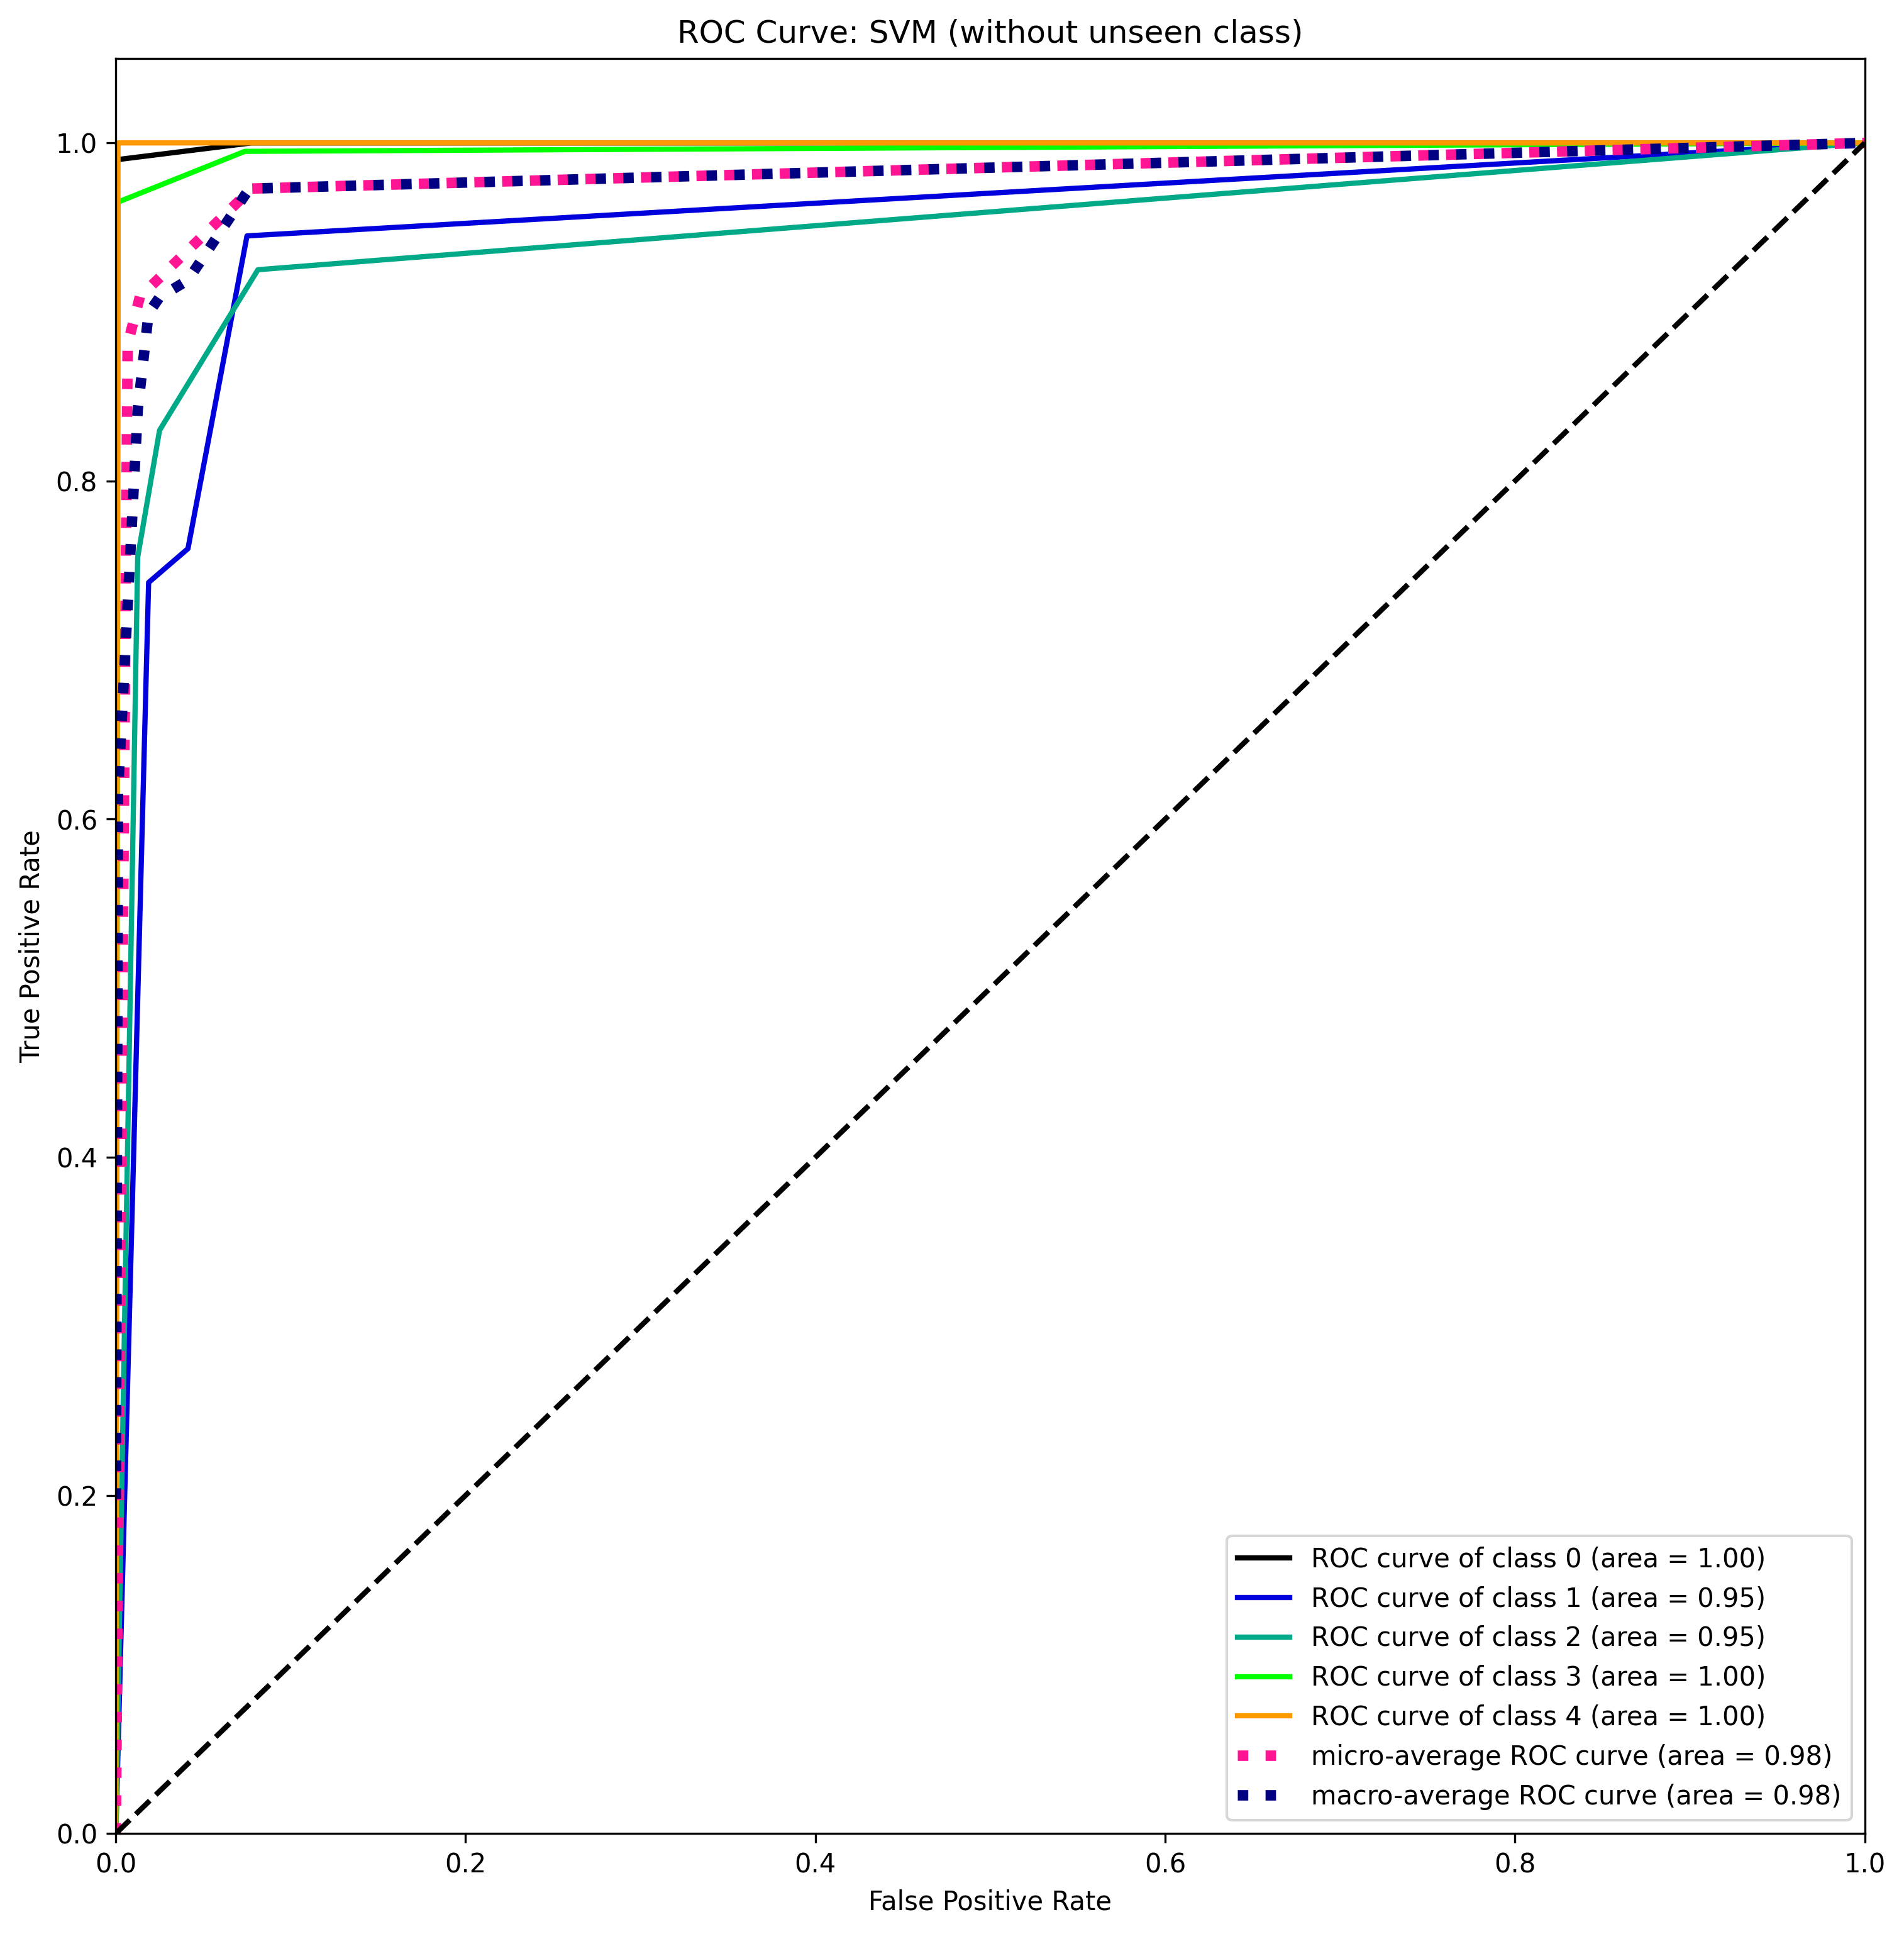

In [10]:
fig_save_path = str(ROOT.joinpath("results", "svm", "without_unseen"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    actual_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix="SVM (without unseen class)",
    save_path=fig_save_path,
)

In [11]:
print_scores(actual_labels, predicted_labels)


    F1 Score: 0.89
    Accuracy: 0.89
    
